# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [33]:
from utils import get_dataset
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import tensorflow as tf

%matplotlib inline

In [34]:
dataset = get_dataset("/home/workspace/data/train/*.tfrecord")

INFO:tensorflow:Reading unweighted datasets: ['/home/workspace/data/train/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/home/workspace/data/train/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 86


## Write a function to display an image and the bounding boxes

Implement the `display_images` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [11]:
def display_images(batch):
    
    colors = {1:"red", 2:"blue", 4:"green"}
    w, h, c = batch["image"].shape
    
    #fig, ax = plt.subplots(figsize = (5,5))
    fig, ax = plt.subplots()
    ax.imshow(batch["image"].numpy().astype("uint8"))
    
    class_labels = batch["groundtruth_classes"].numpy()
    
    for i in range(len(batch["groundtruth_boxes"])):
        ymin, xmin, ymax, xmax = batch["groundtruth_boxes"][i]
        rect = patches.Rectangle((xmin * w, ymin * h), (xmax - xmin) * w, (ymax - ymin) * h, edgecolor=colors[class_labels[i]], facecolor="none")
        ax.add_patch(rect)
        
    plt.show()
        

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

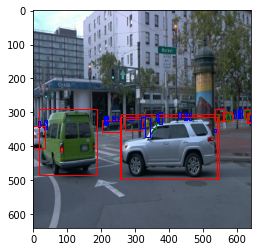

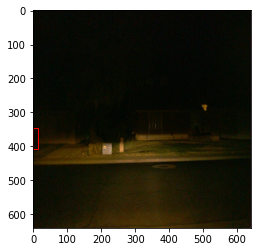

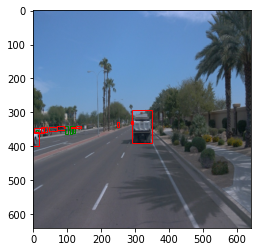

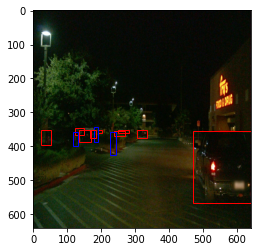

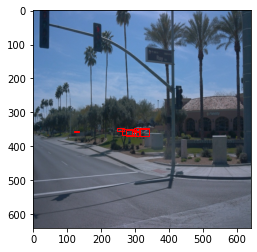

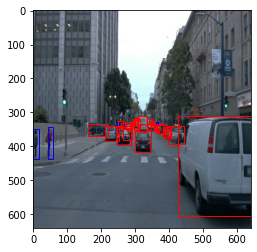

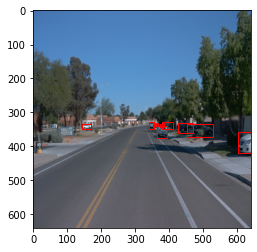

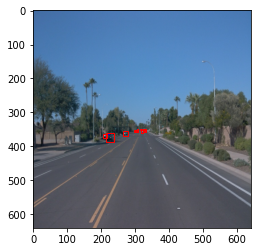

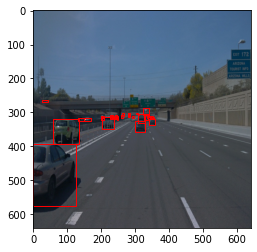

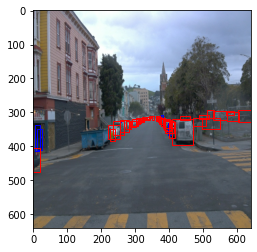

In [12]:
def display_instances():
    for frame in dataset.take(10):
        display_images(frame)
        
display_instances()

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

In [27]:
# Show data structure and features of a frame
print(repr(dataset.take(1)))

<DatasetV1Adapter shapes: {image: (None, None, 3), source_id: (), key: (), filename: (), groundtruth_image_confidences: (None,), groundtruth_verified_neg_classes: (None,), groundtruth_not_exhaustive_classes: (None,), groundtruth_boxes: (None, 4), groundtruth_area: (None,), groundtruth_is_crowd: (None,), groundtruth_difficult: (None,), groundtruth_group_of: (None,), groundtruth_weights: (None,), groundtruth_classes: (None,), groundtruth_image_classes: (None,), original_image_spatial_shape: (2,)}, types: {image: tf.uint8, source_id: tf.string, key: tf.string, filename: tf.string, groundtruth_image_confidences: tf.float32, groundtruth_verified_neg_classes: tf.int64, groundtruth_not_exhaustive_classes: tf.int64, groundtruth_boxes: tf.float32, groundtruth_area: tf.float32, groundtruth_is_crowd: tf.bool, groundtruth_difficult: tf.int64, groundtruth_group_of: tf.bool, groundtruth_weights: tf.float32, groundtruth_classes: tf.int64, groundtruth_image_classes: tf.int64, original_image_spatial_sh

In [37]:
# Function to plot distribution of identified objects
def plot(dataset, n_sample, counts=0, bbox_distrib={}):
    for frame in dataset.take(n_sample):
        # Compute count of object occurence holistically
        gtClasses = frame["groundtruth_classes"].numpy()
        count, bin = np.histogram(gtClasses, bins=[1,2,3,4,5])
        counts += count    
    
        # Compute distribution of num of objects in a frame
        bbox_num = frame["groundtruth_boxes"].numpy().shape[0]    
        if bbox_num in bbox_distrib:
            bbox_distrib[bbox_num] +=1
        else:
            bbox_distrib[bbox_num] = 1
    
    # Plot bar chart of distribution of object occurence in the dataset
    print("Identified objects in Waymo Open dataset:", counts) 
    plt.bar(bins[:-1], counts, align='center', width=0.5, color='blue')
    plt.xticks([1,2,4], ["Vechicles", "Pedestrians", "Cyclists"]) 
    plt.xlabel("Class Label")
    plt.ylabel("Occurrence")
    plt.title("Identified objects in Waymo Open dataset with " + str(n_sample) + " samples")
    plt.show()
    
    # Plot bar chart of distribution of num of objects in a frame
    x = list(range(1, max(bbox_distrib.keys())+ 1))
    y = [bbox_distrib[i] if i in bbox_distrib else 0 for i in x]
    plt.bar(x, y)
    plt.xlabel("Number of objects")
    plt.ylabel("Number of frames")
    plt.title("Distribution of number of identified objects in a single frame")
    plt.show()

Identified objects in Waymo Open dataset: [518691 145567      0   3716]


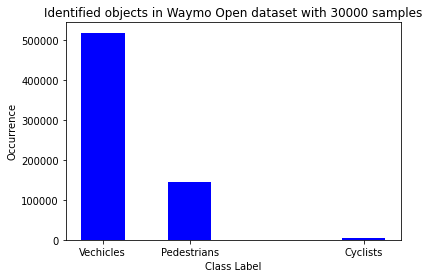

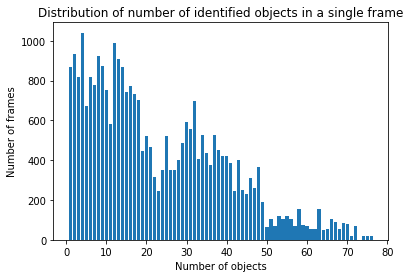

In [39]:
# Plot distribution of identified objects 
plot(dataset, n_sample=30000, counts=0, bbox_distrib={})

Edit TF Object Detection API config files

In [43]:
# Download pretrained model
%cd /home/workspace/experiments/pretrained_model/
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xvzf *.gz
!rm *.gz

/home/workspace/experiments/pretrained_model
--2023-02-28 06:43:55--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.197.128, 2607:f8b0:4001:c1b::80
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.197.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   207MB/s    in 1.1s    

2023-02-28 06:43:56 (207 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]

ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
tar: ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001: Wrote o

In [1]:
# Edit config file
!python edit_config.py --train_dir /home/workspace/data/train/ --eval_dir /home/workspace/data/val/ --batch_size 2 --checkpoint /home/workspace/experiments/pretrained_model/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0 --label_map /home/workspace/experiments/label_map.pbtxt

2023-02-27 18:49:20.935419: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


Modern Training and Evaluation

In [ ]:
# Model training
!python experiments/model_main_tf2.py --model_dir=experiments/reference --pipeline_config_path=experiments/reference/pipeline_new.config

In [34]:
# Monitor training by TensorBoard
!python -m tensorboard.main --logdir=/home/workspace/experiments/reference/train

2023-02-06 08:22:25.136455: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.4.1 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [ ]:
# Model evaluation
!python experiments/model_main_tf2.py --model_dir=experiments/reference/ --pipeline_config_path=experiments/reference/pipeline_new.config --checkpoint_dir=experiments/reference/

In [ ]:
# Save and export model
!python experiments/exporter_main_v2.py --input_type image_tensor --pipeline_config_path experiments/reference/pipeline_new.config --trained_checkpoint_dir experiments/reference/ --output_directory experiments/reference/exported/

In [ ]:
# Create video of the identified objects with sequences
!python inference_video.py --labelmap_path label_map.pbtxt --model_path experiments/reference/exported/saved_model --tf_record_path data/test/segment-12200383401366682847_2552_140_2572_140_with_camera_labels.tfrecord --config_path experiments/reference/pipeline_new.config --output_path animation.gif